<a href="https://colab.research.google.com/github/rogerwender/CientistaDeDados/blob/main/FatoresRotatividadeClienteEmpresaTelefonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Determinar os principais fatores de rotatividade do cliente de empresa de telefonia e prever as chances  de um cliente sair

- Fonte de dados: https://kaggle.com/blastchar/telco-customer-churn
* Coluna Churn: clientes que saíram no último mês
* Serviços que cadas cliente assinou.
* Informações da conta do cliente

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [4]:
!pip install -q -U watermark
%reload_ext watermark
%watermark -a "Ciencia dos dados" --iversions

#Versao do python
from platform import python_version
print("Versao: ", python_version())

numpy   1.19.5
pandas  1.1.5
seaborn 0.11.1
Ciencia dos dados
Versao:  3.6.9


In [5]:
import warnings
import sys
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
if not sys.warnoptions:
  warnings.simplefilter("ignore")

In [7]:
dataframe = pd.read_csv('/content/sample_data/Telco-Customer-Churn.csv')

print(dataframe.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
#Verificando valores duplicados
dataframe.duplicated().sum()

0

In [9]:
#Visualizando o dataframe
dataframe.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
#Verificando valores missing - valores ausentes
dataframe.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

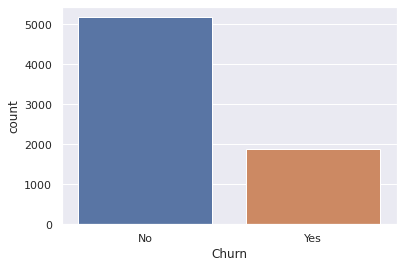

In [12]:
#Verificando valores balanceados - clientes que evadiram
dataframe['Churn'].value_counts()
sns.countplot(dataframe['Churn'])

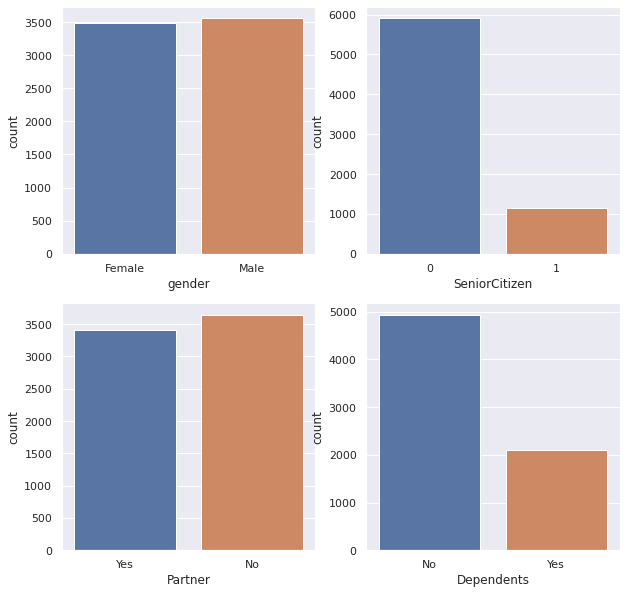

In [13]:
#Verificar as estatisticas frequentes deste clientes
f, ax = plt.subplots(2,2, figsize=(10,10))

sns.countplot(dataframe['gender'], ax=ax[0,0])
sns.countplot(dataframe['SeniorCitizen'], ax=ax[0,1])
sns.countplot(dataframe['Partner'], ax=ax[1,0])
sns.countplot(dataframe['Dependents'], ax=ax[1,1])


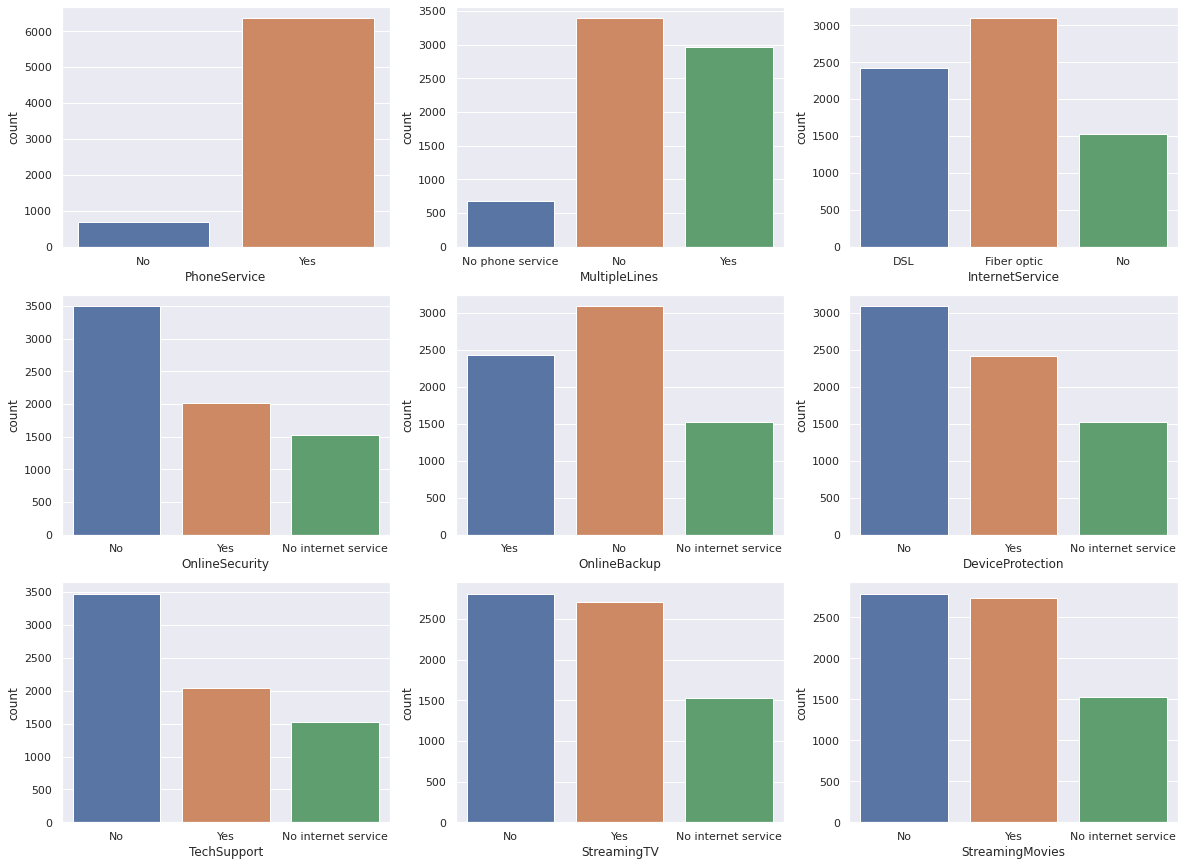

In [15]:
f, ax = plt.subplots(3,3, figsize=(20,15))

sns.countplot(dataframe['PhoneService'], ax=ax[0,0])
sns.countplot(dataframe['MultipleLines'], ax=ax[0,1])
sns.countplot(dataframe['InternetService'], ax=ax[0,2])
sns.countplot(dataframe['OnlineSecurity'], ax=ax[1,0])
sns.countplot(dataframe['OnlineBackup'], ax=ax[1,1])
sns.countplot(dataframe['DeviceProtection'], ax=ax[1,2])
sns.countplot(dataframe['TechSupport'], ax=ax[2,0])
sns.countplot(dataframe['StreamingTV'], ax=ax[2,1])
sns.countplot(dataframe['StreamingMovies'], ax=ax[2,2])

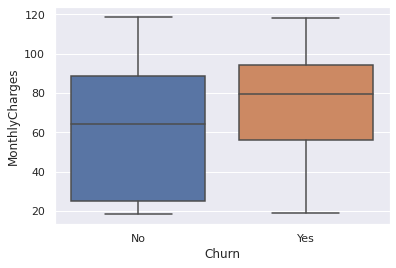

In [16]:
#Pagamentos mensais
sns.boxplot('Churn', 'MonthlyCharges', data=dataframe)

In [17]:
#Estatisticas descritivas
dataframe.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


#Processamento dos dados

In [18]:
#Removendo a coluna ID
dataframe.drop(['customerID'], axis=1, inplace=True)

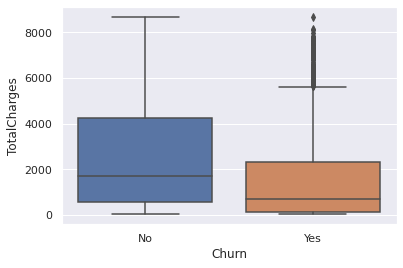

In [19]:
#Convertendo colunas numericas para string
dataframe['TotalCharges'] = dataframe['TotalCharges'].replace(' ', np.nan)
dataframe.isna().sum()
dataframe.dropna(inplace=True)

dataframe['TotalCharges'] = pd.to_numeric(dataframe['TotalCharges'])

sns.boxplot("Churn", 'TotalCharges', data=dataframe)

In [21]:
#Convertendo tipos 
dataframe['Churn'].replace('Yes', 1, inplace=True)
dataframe['Churn'].replace('No', 0, inplace=True)

dataframe['SeniorCitizen'].replace(1, 'Yes', inplace=True)
dataframe['SeniorCitizen'].replace(0, 'No', inplace=True)

#criando novas variaveis
dataframe_onehot = pd.get_dummies(dataframe)
dataframe_onehot.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


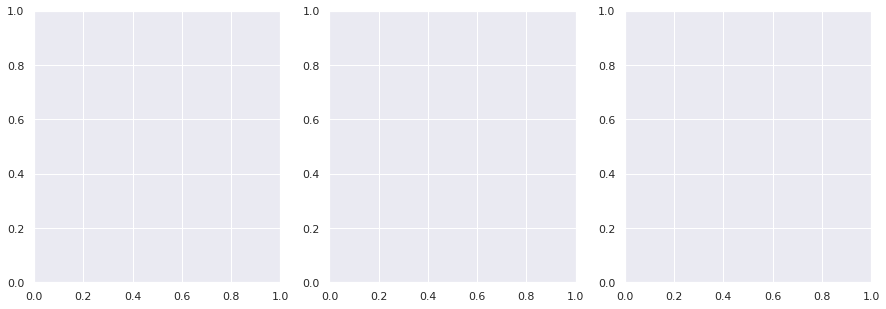

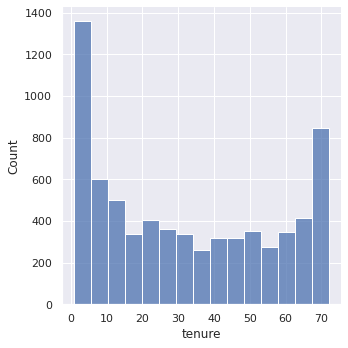

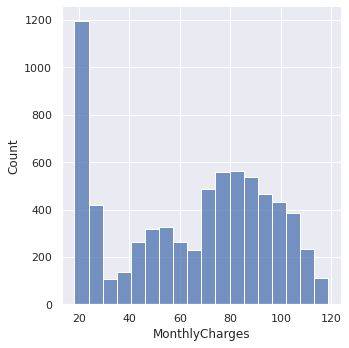

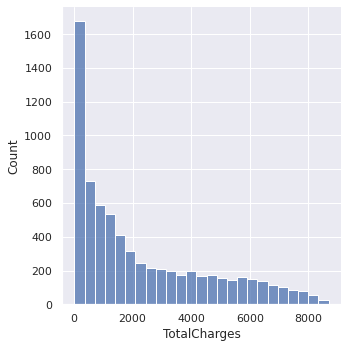

In [22]:
#plotando os valores
f, ax = plt.subplots(1,3, figsize=(15,5))

sns.displot(dataframe_onehot['tenure'], ax=ax[0])
sns.displot(dataframe_onehot['MonthlyCharges'], ax=ax[1])
sns.displot(dataframe_onehot['TotalCharges'], ax=ax[2])


In [23]:
#Transformando os valores para escalas
scaler = MinMaxScaler()
dataframe_onehot['tenure'] = scaler.fit_transform(dataframe_onehot['tenure'].values.reshape(-1,1))
dataframe_onehot['MonthlyCharges'] = scaler.fit_transform(dataframe_onehot['MonthlyCharges'].values.reshape(-1,1))
dataframe_onehot['TotalCharges'] = scaler.fit_transform(dataframe_onehot['TotalCharges'].values.reshape(-1,1))


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


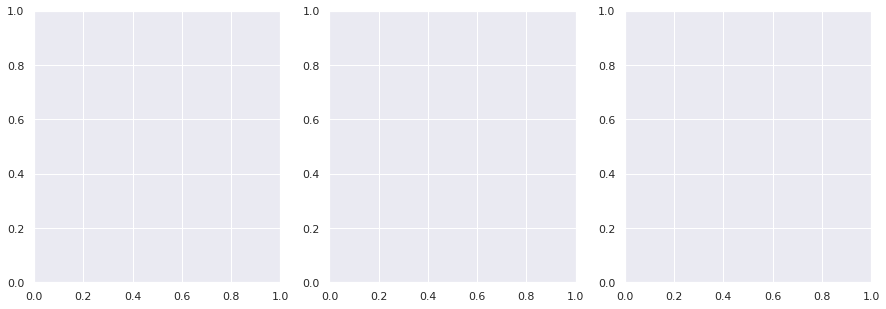

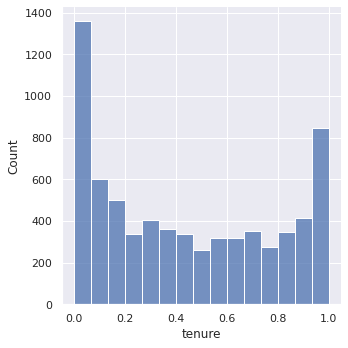

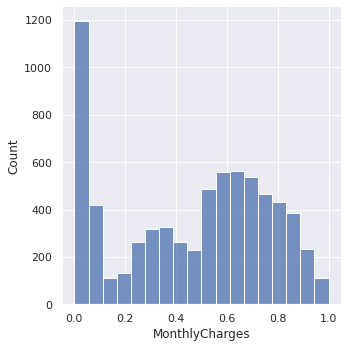

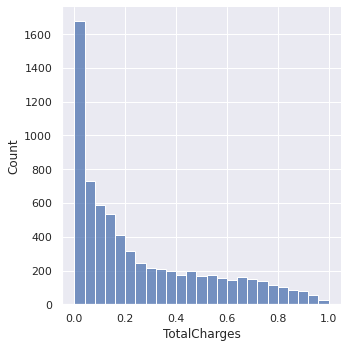

In [24]:
#Plotando os valores apos a escalabilidade
f, ax = plt.subplots(1,3, figsize=(15,5))

sns.displot(dataframe_onehot['tenure'], ax=ax[0])
sns.displot(dataframe_onehot['MonthlyCharges'], ax=ax[1])
sns.displot(dataframe_onehot['TotalCharges'], ax=ax[2])

In [31]:
#fatiando o dataset
X = dataframe_onehot.drop(['Churn'], axis=1) #X são todas as colunas menos a coluna Churn
y = dataframe_onehot['Churn'].values.reshape(-1,1) #y é somente a coluna Churn

#20% da amostra de treino para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

#Contruindo as maquinas preditivas

In [32]:
#Usando a regressao logistica para ver se o cliente vai ou nao evadir da empresa
model = LogisticRegression()
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
actual_vs_predict = pd.DataFrame({'Actual': y_test.flatten(),
                                  'Prediction': y_predict.flatten()})
print (actual_vs_predict.sample(12))

      Actual  Prediction
838        1           0
1005       0           0
1108       0           0
449        0           0
943        0           0
1271       0           0
1264       0           0
1404       0           0
930        0           1
734        1           0
265        1           0
627        0           1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#Avaliacao da maquina preditiva - Baseline

ROC AUC: 71.52 %


Text(0, 0.5, 'true positive rate')

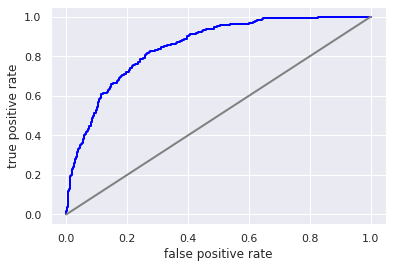

In [33]:

print('ROC AUC: %.2f' %(roc_auc_score(y_test, y_predict)*100), '%')

y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw=2, color='blue')
plt.plot([0,1], [0,1], lw=2, color='gray')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

#Batendo o baseline com GBM - Gradient Boosting

In [43]:
#Usando a regressao logistica para ver se o cliente vai ou nao evadir da empresa
model = GradientBoostingClassifier (learning_rate=0.1, max_depth=2, n_estimators=200, max_features=8, random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
actual_vs_predict = pd.DataFrame({'Actual': y_test.flatten(),
                                  'Prediction': y_predict.flatten()})
print (actual_vs_predict.sample(12))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Actual  Prediction
927        0           0
388        0           0
1014       0           0
515        1           1
257        1           1
223        1           1
1091       0           1
50         0           0
914        0           1
49         0           0
926        1           1
107        1           0


ROC AUC: 71.64 %


Text(0, 0.5, 'true positive rate')

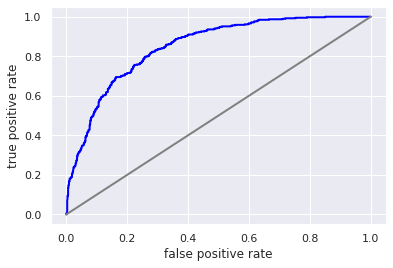

In [44]:
print('ROC AUC: %.2f' %(roc_auc_score(y_test, y_predict)*100), '%')

y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw=2, color='blue')
plt.plot([0,1], [0,1], lw=2, color='gray')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

In [45]:
#Batendo o baseline com XGBOOST - Extreme Gradient boosting
#Usando a regressao logistica para ver se o cliente vai ou nao evadir da empresa
model = XGBClassifier (max_depth=2, learning_rate=0.1, n_estimators=200)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
actual_vs_predict = pd.DataFrame({'Actual': y_test.flatten(),
                                  'Prediction': y_predict.flatten()})
print (actual_vs_predict.sample(12))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Actual  Prediction
645        0           0
1232       1           1
852        0           0
302        0           0
987        0           0
452        0           0
296        0           0
364        0           0
113        1           0
1215       0           0
790        0           0
1359       1           1


ROC AUC: 71.55 %


Text(0, 0.5, 'true positive rate')

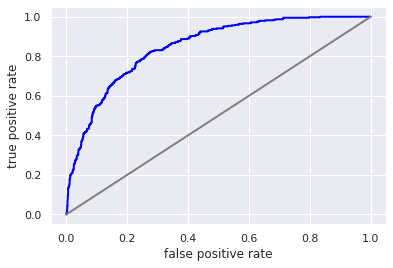

In [47]:
print('ROC AUC: %.2f' %(roc_auc_score(y_test, y_predict)*100), '%')

y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw=2, color='blue')
plt.plot([0,1], [0,1], lw=2, color='gray')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

Neste exemplo temos uma maquina preditiva para determinar a probabilidade de saída de clientes das empresas de telefonia.